In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib
import os
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv("./correlation-data/r22-24_processed.csv")
df["race"] = pd.factorize(df["race"])[0]
df = df.drop(columns=["race"])
df["LapTime"] = df["LapTime"] - df["racemean"]
df = df.drop(columns=["racemean", "SpL", "CornerForce", "TempRatio"])
df_dry = df[df["Rainfall"] == 0.0]
df_dry = df_dry.drop(columns=["Rainfall"])
X_dry = df_dry.drop(columns=['LapTime'])
y_dry = df_dry['LapTime']
df_wet = df[df["Rainfall"] == 1.0]
df_wet = df_wet.drop(columns=["Rainfall"])
X_wet = df_wet.drop(columns=['LapTime'])
y_wet = df_wet['LapTime']
df = df.drop(columns=["Rainfall"])

X = df.drop(columns=['LapTime'])
y = df['LapTime']

categorical_feats = ['Compound', "Rainfall", "LapNumber", "Stint", "TyreLife"]
categorical_feats = [c for c in X.columns if c.startswith(tuple(categorical_feats))]
numerical_features = [c for c in X.columns if not c.startswith(tuple(categorical_feats))]

# #Remove Compound_INTERMEDIATE and Compound_WET from dry dataset
X_dry = X_dry.drop(columns=["Compound_INTERMEDIATE", "Compound_WET"])

X_dry_train, X_dry_test, y_dry_train, y_dry_test = train_test_split(X_dry, y_dry, test_size=0.2, random_state=135135)
X_wet_train, X_wet_test, y_wet_train, y_wet_test = train_test_split(X_wet, y_wet, test_size=0.2, random_state=25351)

In [2]:
def make_pipeline(n_est,random_state,max_depth=None,):
    return Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
            ], remainder='passthrough')),
        ('rf', RandomForestRegressor(n_estimators=n_est, max_depth=max_depth,  random_state=random_state, n_jobs=-1))
    ])

In [18]:
# Run if you're gonna do CV on train set
# 50 est 15 depth

# try_est = [5,50,100,200,300,500]
# try_depth = [5,10,15,20,30,50,100]
# for depth in try_depth:
#     pipeline_dry = make_pipeline(n_est=50, random_state=23535, max_depth=depth)
#     result = cross_validate(pipeline_dry, X_dry_train, y_dry_train, cv=KFold(n_splits=10,shuffle=True, random_state=8574), scoring='neg_root_mean_squared_error', return_train_score=True)
#     print(f"Depth: {depth} - Train RMSE: {-result['train_score'].mean():.4f}, Test RMSE: {-result['test_score'].mean():.4f}")

# # Train of full train set and test on test set
pipeline_dry = make_pipeline(n_est=50, random_state=658533, max_depth=15)
pipeline_dry.fit(X_dry_train, y_dry_train)

test_preds_dry = pipeline_dry.predict(X_dry_test)
rmse_dry_test = root_mean_squared_error(y_dry_test, test_preds_dry)
print(f"Dry Test RMSE: {rmse_dry_test:.4f}")
#Baseline test RMSE
baseline_pred = root_mean_squared_error(y_dry_test, [0] * len(y_dry_test))
print(f"Baseline Test RMSE: {baseline_pred:.4f}")

Dry Test RMSE: 0.9241
Baseline Test RMSE: 1.7491


In [19]:
# Run if you're gonna do CV on train set
# 50 est 15 depth

# try_est = [5,50,100,200,300,500]
# try_depth = [5,10,15,20,30,50,100]
# for depth in try_depth:
#     pipeline_wet = make_pipeline(n_est=50, random_state=23535, max_depth=depth)
#     result = cross_validate(pipeline_wet, X_wet_train, y_wet_train, cv=KFold(n_splits=10,shuffle=True, random_state=7654), scoring='neg_root_mean_squared_error', return_train_score=True)
#     print(f"Depth: {depth} - Train RMSE: {-result['train_score'].mean():.4f}, Test RMSE: {-result['test_score'].mean():.4f}")

# # Train of full train set and test on test set
pipeline_wet = make_pipeline(n_est=50, random_state=362, max_depth=15)
pipeline_wet.fit(X_wet_train, y_wet_train)
test_preds_wet = pipeline_wet.predict(X_wet_test)
rmse_wet_test = root_mean_squared_error(y_wet_test, test_preds_wet)
print(f"Wet Test RMSE: {rmse_wet_test:.4f}")
#Baseline test RMSE
baseline_pred = root_mean_squared_error(y_wet_test, [0] * len(y_wet_test))
print(f"Baseline Test RMSE: {baseline_pred:.4f}")
# Train RMSE wet
train_preds_wet = pipeline_wet.predict(X_wet_train)
rmse_wet_train = root_mean_squared_error(y_wet_train, train_preds_wet)
print(f"Wet Train RMSE: {rmse_wet_train:.4f}")


Wet Test RMSE: 1.7822
Baseline Test RMSE: 5.7180
Wet Train RMSE: 0.8075


In [3]:
#Dont train if models already exist and load them instead
if os.path.exists("./models/pipeline_dry.pkl") and os.path.exists("./models/pipeline_wet.pkl"):
    print("Loading existing models...")
    pipeline_dry = joblib.load("./models/pipeline_dry.pkl")
    pipeline_wet = joblib.load("./models/pipeline_wet.pkl")
else:
    print("Training new models...")
    # Train on full dataset
    pipeline_dry = make_pipeline(n_est=50, random_state=56334, max_depth=15)
    pipeline_dry.fit(X_dry, y_dry)
    pipeline_wet = make_pipeline(n_est=50, random_state=3474, max_depth=15)
    pipeline_wet.fit(X_wet, y_wet)
    # Save the models
    os.makedirs("./models", exist_ok=True)
    joblib.dump(pipeline_dry, "./models/pipeline_dry.pkl")
    joblib.dump(pipeline_wet, "./models/pipeline_wet.pkl")

Loading existing models...


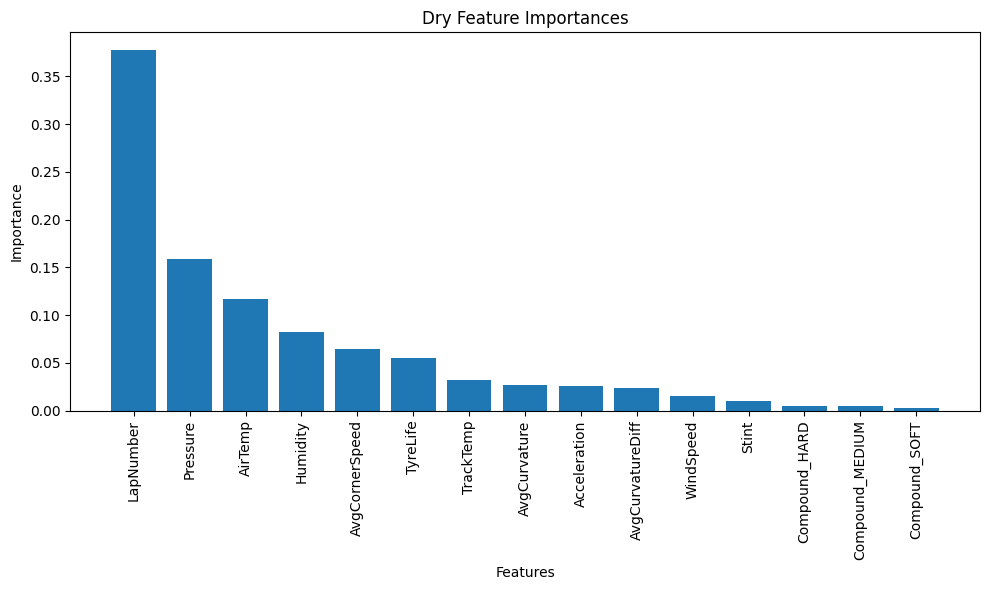

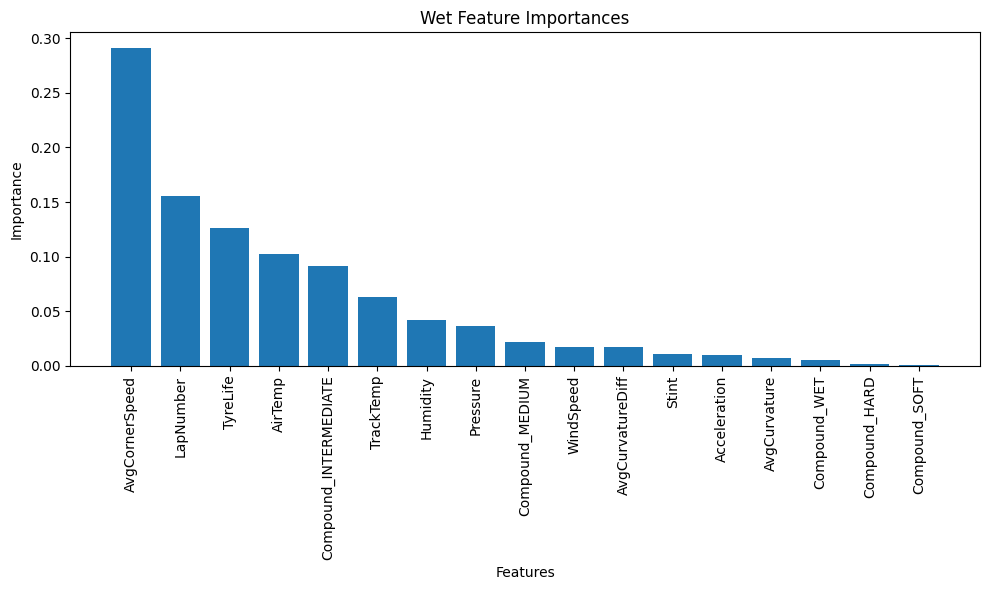

In [85]:
# Feature importances
def plot_feature_importances(pipeline, title, feature_names):
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out(feature_names)
    # Strip off the prefix from the feature names
    feature_names = [name.split('__')[-1] for name in feature_names]
    importances = pipeline.named_steps['rf'].feature_importances_
    indices = importances.argsort()[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    

plot_feature_importances(pipeline_dry, "Dry Feature Importances", X_dry.columns.tolist())
plt.savefig("./plots/dry/barplot.svg")
plt.show()
plot_feature_importances(pipeline_wet, "Wet Feature Importances", X_wet.columns.tolist())
plt.savefig("./plots/wet/barplot.svg")
plt.show()

In [23]:
import shap

dry_feature_names = pipeline_dry.named_steps["preprocessor"].get_feature_names_out(X_dry.columns.tolist())
# Strip off the prefix from the feature names
dry_feature_names = [name.split('__')[-1] for name in dry_feature_names]
# Change AvgCornerSpeed to AvgCornerExitSpeed
dry_feature_names = [name.replace("AvgCornerSpeed", "AvgCornerExitSpeed") for name in dry_feature_names]

X_dry_sample = X_dry.sample(n=10000, random_state=56446)
X_dry_sample_scaled = pipeline_dry.named_steps['preprocessor'].transform(X_dry_sample)

In [6]:
#If explainer and shap values already exist, load them
if os.path.exists("./shap/explainer_dry.pkl") and os.path.exists("./shap/shap_values_dry.pkl"):
    print("Loading existing SHAP explainer and values...")
    explainer_dry = joblib.load("./shap/explainer_dry.pkl")
    shap_values_dry = joblib.load("./shap/shap_values_dry.pkl")
else:
    explainer_dry = shap.TreeExplainer(pipeline_dry.named_steps['rf'], feature_names=dry_feature_names)
    shap_values_dry = explainer_dry.shap_values(X_dry_sample_scaled)

    #Save the explainer and shap values
    os.makedirs("./shap", exist_ok=True)
    joblib.dump(explainer_dry, "./shap/explainer_dry.pkl")
    joblib.dump(shap_values_dry, "./shap/shap_values_dry.pkl")

Loading existing SHAP explainer and values...


In [7]:
#Wet shap
wet_feature_names = pipeline_wet.named_steps["preprocessor"].get_feature_names_out(X_wet.columns.tolist())
# Strip off the prefix from the feature names
wet_feature_names = [name.split('__')[-1] for name in wet_feature_names]
X_wet_sample = X_wet.sample(n=5000, random_state=734346)
X_wet_sample_scaled = pipeline_wet.named_steps['preprocessor'].transform(X_wet_sample)

#If explainer and shap values already exist, load them
if os.path.exists("./shap/explainer_wet.pkl") and os.path.exists("./shap/shap_values_wet.pkl"):
    print("Loading existing SHAP explainer and values...")
    explainer_wet = joblib.load("./shap/explainer_wet.pkl")
    shap_values_wet = joblib.load("./shap/shap_values_wet.pkl")
else:
    explainer_wet = shap.TreeExplainer(pipeline_wet.named_steps['rf'], feature_names=wet_feature_names)
    shap_values_wet = explainer_wet.shap_values(X_wet_sample_scaled)

    #Save the explainer and shap values
    os.makedirs("./shap", exist_ok=True)
    joblib.dump(explainer_wet, "./shap/explainer_wet.pkl")
    joblib.dump(shap_values_wet, "./shap/shap_values_wet.pkl")

Loading existing SHAP explainer and values...


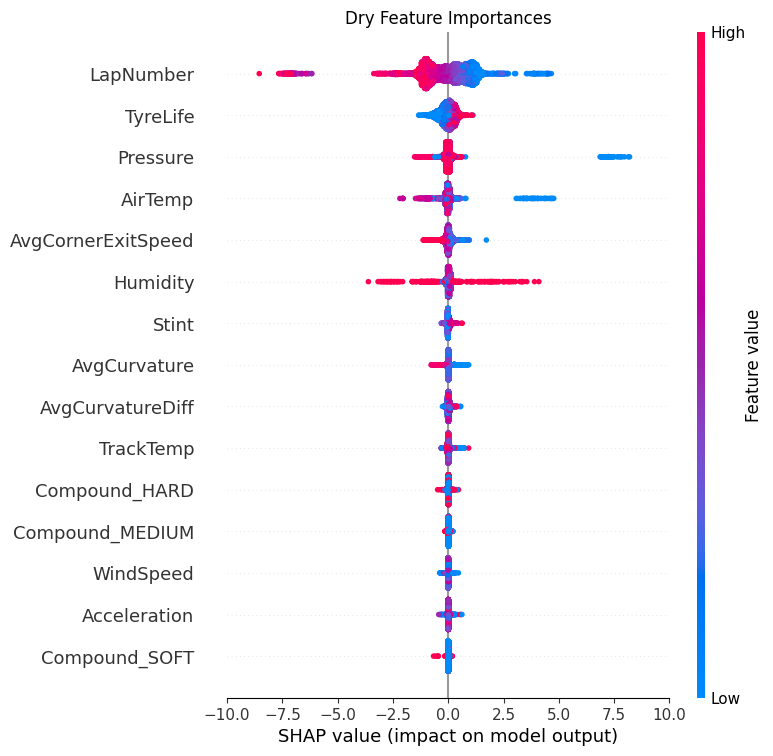

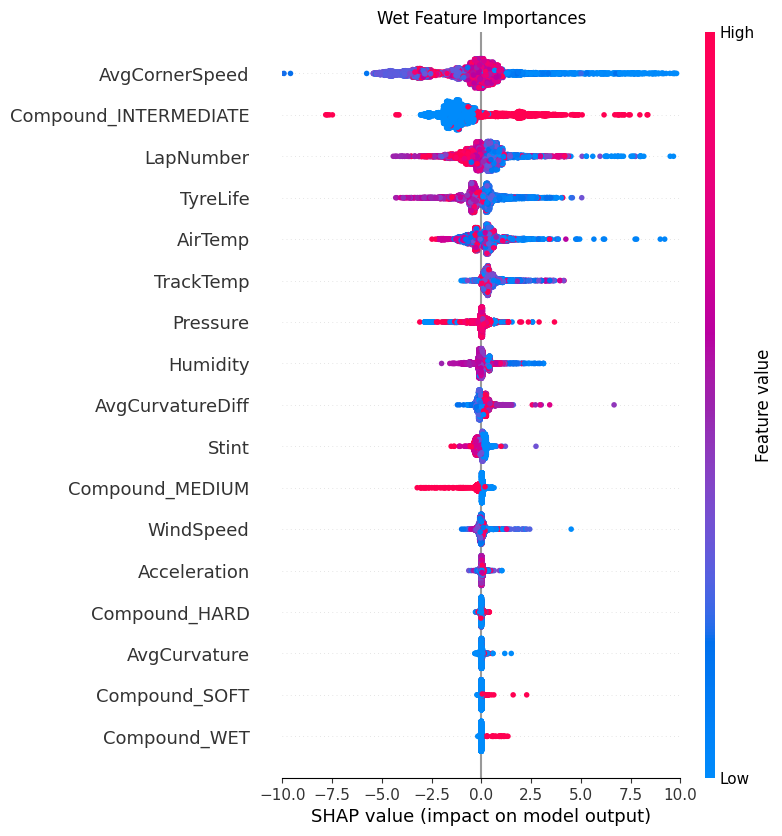

In [83]:
#Plot SHAP feature importances of top 5
shap.summary_plot(shap_values_dry, X_dry_sample_scaled, feature_names=dry_feature_names, show=False)
plt.title("Dry Feature Importances")
ax = plt.gca()
ax.set_xlim(-10, 10)  # Adjust x-axis limits to focus on the most important features
plt.savefig("./plots/dry/main.svg")
plt.show()
shap.summary_plot(shap_values_wet, X_wet_sample_scaled, feature_names=wet_feature_names, show=False)
plt.title("Wet Feature Importances")
ax = plt.gca()
ax.set_xlim(-10, 10)
plt.savefig("./plots/wet/main.svg")
plt.show()

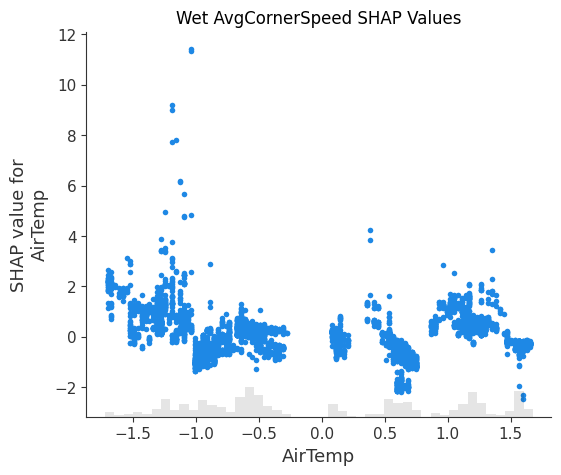

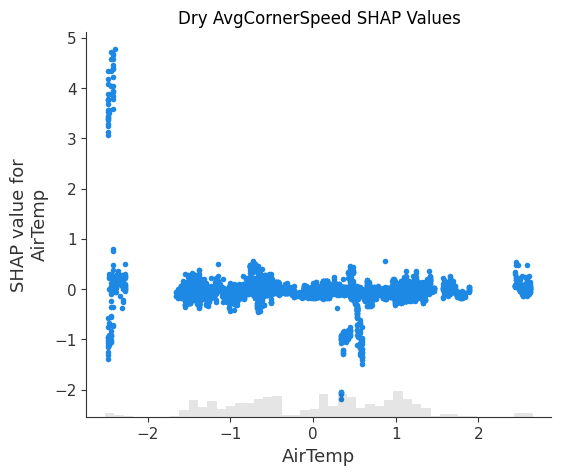

In [48]:
# Create shap.Explanation from shap values dry
shap_explanation_dry = shap.Explanation(values=shap_values_dry, 
                                         data=X_dry_sample_scaled, 
                                         feature_names=dry_feature_names)
shap_explanation_wet = shap.Explanation(values=shap_values_wet,
                                         data=X_wet_sample_scaled, 
                                         feature_names=wet_feature_names)
shap.plots.scatter(shap_explanation_wet[:, "AirTemp"], show=False)
plt.title("Wet AvgCornerSpeed SHAP Values")
plt.show()
shap.plots.scatter(shap_explanation_dry[:, "AirTemp"], show=False)
plt.title("Dry AvgCornerSpeed SHAP Values")
plt.show()

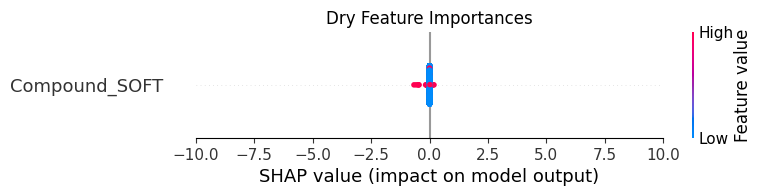

In [81]:
import os
os.makedirs("./plots/dry", exist_ok=True)
#Plot SHAP feature importances of top 5
for i in range(len(dry_feature_names)):
    feat_slice = slice(i, i+1)
    shap.summary_plot(shap_values_dry[:, feat_slice], X_dry_sample_scaled[:, feat_slice], feature_names=dry_feature_names[feat_slice], show=False)
    plt.title("Dry Feature Importances")
    ax = plt.gca()
    ax.set_xlim(-10, 10)  # Adjust x-axis limits to focus on the most important features
    plt.savefig(f"./plots/dry/feature_importance_{dry_feature_names[i]}.svg")

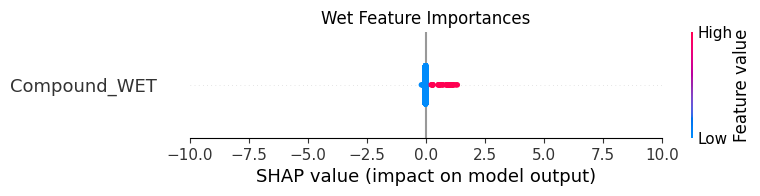

In [82]:
import os
os.makedirs("./plots/wet", exist_ok=True)
#Plot SHAP feature importances of top 5
for i in range(len(wet_feature_names)):
    feat_slice = slice(i, i+1)
    shap.summary_plot(shap_values_wet[:, feat_slice], X_wet_sample_scaled[:, feat_slice], feature_names=wet_feature_names[feat_slice], show=False)
    plt.title("Wet Feature Importances")
    ax = plt.gca()
    ax.set_xlim(-10, 10)  # Adjust x-axis limits to focus on the most important features
    plt.savefig(f"./plots/wet/feature_importance_{wet_feature_names[i]}.svg")